In [1]:
import pandas as pd
df = pd.read_csv('C:\\Users\\17376\\Desktop\\CYX\\study\\5261 Finance\\61project\\data\\weekly_master_edited.csv')
df_cleaned = df.iloc[:-2, :]
df_cleaned = df_cleaned.iloc[:, :9]
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
df_new = df_cleaned[df_cleaned['date'] >= pd.to_datetime('2000-12-02')].copy()
df_new = df_new[:-1].copy()
import numpy as np
df_new['boeing_log_return'] = np.log(df_new['boeing'] / df_new['boeing'].shift(1))
df_new['boeing_return'] = df_new['boeing'].pct_change()
print(df_new.tail())

           date  boeing       DJI      dollar        oil        GDP       CPI  \
1306 2025-01-11  171.09  43487.83  109.349998  72.259014  27967.697  0.190752   
1307 2025-01-18  176.06  44424.25  107.440002  72.019843  27967.697  0.190752   
1308 2025-01-25  176.52  44544.66  108.370003  71.780671  27967.697  0.190752   
1309 2025-02-01  181.49  44303.40  108.040001  71.541500  27967.697  0.190752   
1310 2025-02-08  180.55  44546.08  106.570000  71.541500  27967.697  0.190752   

      delivery           Al  boeing_log_return  boeing_return  
1306      44.0  2582.188571          -0.005305      -0.005291  
1307      44.0  2582.188571           0.028635       0.029049  
1308      44.0  2582.188571           0.002609       0.002613  
1309      44.0  2582.188571           0.027766       0.028155  
1310      44.0  2582.188571          -0.005193      -0.005179  


In [3]:
#标准化
from sklearn.preprocessing import StandardScaler
exog_cols = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_exog = df_new[exog_cols]
scaler = StandardScaler()
X_exog_scaled = scaler.fit_transform(X_exog)
X_exog_scaled_df = pd.DataFrame(X_exog_scaled, columns=exog_cols, index=df_new.index)
final_df = pd.concat([
    df_new[['date', 'boeing', 'boeing_return']],
    X_exog_scaled_df
], axis=1)
print(final_df.head())

         date    boeing  boeing_return       DJI    dollar       oil  \
48 2000-12-02  45.69375            NaN -0.799761  1.992524 -1.691842   
49 2000-12-09  42.38616      -0.072386 -0.828734  1.888635 -1.694760   
50 2000-12-16  41.44696      -0.022158 -0.807823  1.700732 -1.697677   
51 2000-12-23  43.12119       0.040395 -0.791934  1.586906 -1.700595   
52 2000-12-30  38.38439      -0.109849 -0.805066  1.483920 -1.703513   

         GDP       CPI  delivery        Al  
48 -1.432307  0.387443 -0.309376 -1.103970  
49 -1.430275  0.396801 -0.306610 -1.112779  
50 -1.428244  0.406159 -0.303844 -1.121588  
51 -1.426212  0.415517 -0.301078 -1.130397  
52 -1.424181  0.424875 -0.298312 -1.139206  


In [4]:
#划分train和test
final_df_cleaned = final_df.iloc[1:].reset_index(drop=True)
train_size = int(0.7 * len(final_df_cleaned))  # 取70%的行数
train_df = final_df_cleaned.iloc[:train_size].copy()
test_df = final_df_cleaned.iloc[train_size:].copy()
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print(train_df.head())
print(test_df.head())

Train shape: (883, 10)
Test shape: (379, 10)
        date    boeing  boeing_return       DJI    dollar       oil       GDP  \
0 2000-12-09  42.38616      -0.072386 -0.828734  1.888635 -1.694760 -1.430275   
1 2000-12-16  41.44696      -0.022158 -0.807823  1.700732 -1.697677 -1.428244   
2 2000-12-23  43.12119       0.040395 -0.791934  1.586906 -1.700595 -1.426212   
3 2000-12-30  38.38439      -0.109849 -0.805066  1.483920 -1.703513 -1.424181   
4 2001-01-06  39.60942       0.031915 -0.819308  1.568838 -1.706430 -1.422149   

        CPI  delivery        Al  
0  0.396801 -0.306610 -1.112779  
1  0.406159 -0.303844 -1.121588  
2  0.415517 -0.301078 -1.130397  
3  0.424875 -0.298312 -1.139206  
4  0.434233 -0.295546 -1.148015  
          date    boeing  boeing_return       DJI    dollar       oil  \
883 2017-11-11  249.9319       0.010810  0.518366  0.150532 -0.497779   
884 2017-11-18  253.3818       0.013803  0.539188  0.069228 -0.479521   
885 2017-11-25  258.6232       0.020686  0.60

In [7]:
import statsmodels.api as sm
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars]
y_train = train_df['boeing_return']
# 拟合ARIMAX模型
model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1), 
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:          boeing_return   No. Observations:                  883
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1554.474
Date:                Wed, 30 Apr 2025   AIC                          -3088.948
Time:                        18:43:27   BIC                          -3041.137
Sample:                             0   HQIC                         -3070.665
                                - 883                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DJI            0.0178      0.010      1.707      0.088      -0.003       0.038
dollar        -0.0092      0.003     -2.761      0.006      -0.016      -0.003
oil           -0.0028      0.004     -0.737      0.4

C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


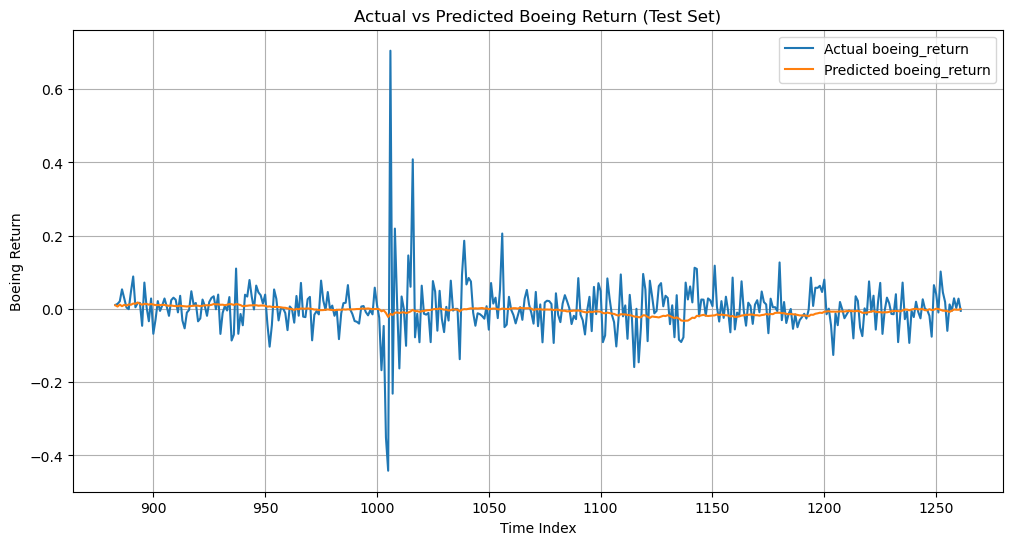

In [9]:
import matplotlib.pyplot as plt
X_test = test_df[exog_vars]
y_test = test_df['boeing_return']
start = len(X_train)
end = start + len(X_test) - 1
y_pred = model_fit.predict(start=start, end=end, exog=X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual boeing_return')
plt.plot(y_test.index, y_pred, label='Predicted boeing_return')
plt.title('Actual vs Predicted Boeing Return (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('Boeing Return')
plt.legend()
plt.grid(True)
plt.show()

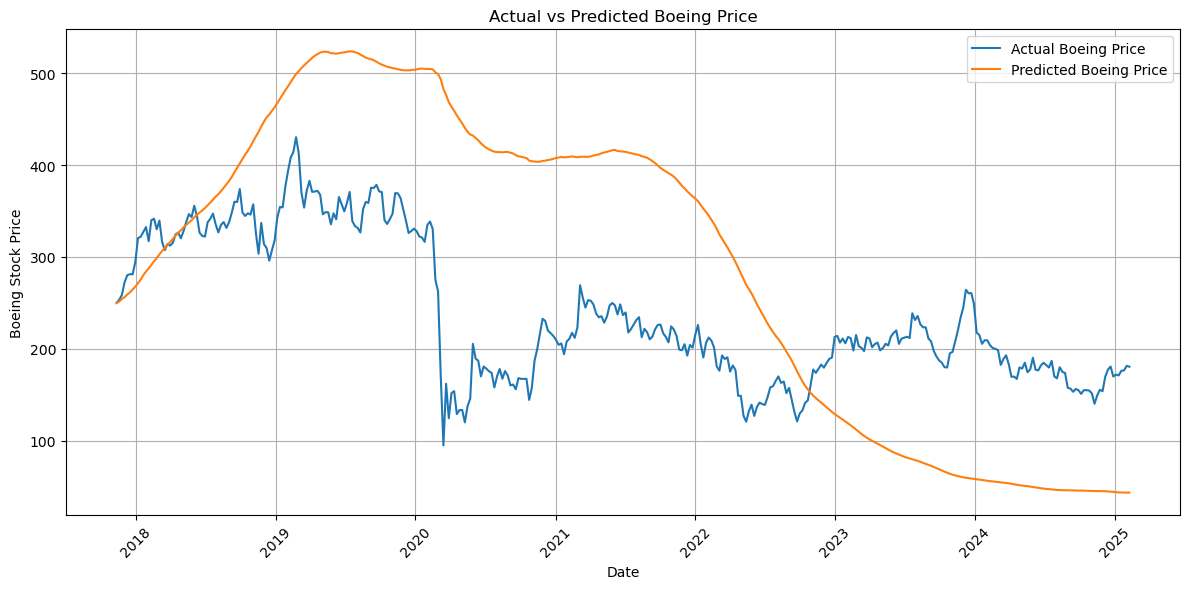

In [11]:
import matplotlib.pyplot as plt
import numpy as np

price_start = train_df['boeing'].iloc[-1]
predicted_price = [price_start * (1 + y_pred.iloc[0])]
for r in y_pred.iloc[1:]:
    predicted_price.append(predicted_price[-1] * (1 + r))
predicted_price = np.array(predicted_price)
real_price = test_df['boeing'].values
real_date = test_df['date'].values  # 日期

plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price')
plt.plot(real_date, predicted_price, label='Predicted Boeing Price')
plt.title('Actual vs Predicted Boeing Price')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # 日期标签旋转45度，更清晰
plt.tight_layout()
plt.show()


In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 真实价格 (test集)
real_price = test_df['boeing'].values
# 预测价格 (之前还原出来的)
# 已经是 predicted_price
# 1. 计算MSE
mse = mean_squared_error(real_price, predicted_price)
# 2. 计算RMSE
rmse = np.sqrt(mse)
# 3. 计算MAE
mae = mean_absolute_error(real_price, predicted_price)
# 4. 计算MAPE
mape = np.mean(np.abs((real_price - predicted_price) / real_price)) * 100
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

MSE: 22940.7973
RMSE: 151.4622
MAE: 134.3255
MAPE: 65.13%


In [15]:
#rolling
import statsmodels.api as sm
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars]
y_train = train_df['boeing_return']
model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),  # 这里先用(1,0,1)，后面如果要调参可以换
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          boeing_return   No. Observations:                  883
Model:               SARIMAX(1, 0, 1)   Log Likelihood                1554.474
Date:                Wed, 30 Apr 2025   AIC                          -3088.948
Time:                        18:43:42   BIC                          -3041.137
Sample:                             0   HQIC                         -3070.665
                                - 883                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DJI            0.0178      0.010      1.707      0.088      -0.003       0.038
dollar        -0.0092      0.003     -2.761      0.006      -0.016      -0.003
oil           -0.0028      0.004     -0.737      0.4

C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [17]:
X_test = test_df[exog_vars]
y_test = test_df['boeing_return']
y_pred_roll = []
y_history = y_train.copy()
X_history = X_train.copy()

for i in range(len(X_test)):
    X_exog_next = X_test.iloc[i:i+1]
    model = sm.tsa.SARIMAX(
        endog=y_history,
        exog=X_history,
        order=(1, 0, 1),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)
    pred_next = model_fit.predict(start=len(y_history), end=len(y_history), exog=X_exog_next)
    y_pred_roll.append(pred_next.iloc[0])
    y_history = pd.concat([y_history, pd.Series(y_test.iloc[i])], axis=0).reset_index(drop=True)
    X_history = pd.concat([X_history, X_exog_next], axis=0).reset_index(drop=True)
y_pred_roll = np.array(y_pred_roll)


C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

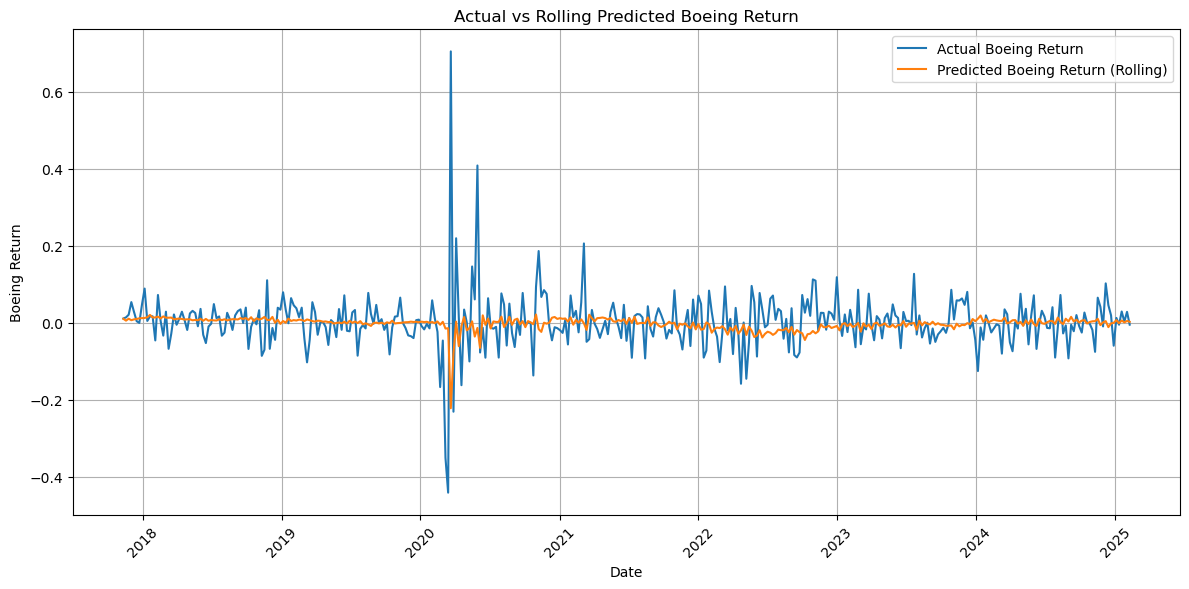

In [47]:
import matplotlib.pyplot as plt

# 真实的 boeing_return
y_test_true = test_df['boeing_return'].values
real_date = test_df['date'].values

# 滚动预测的 boeing_return
y_pred_roll  # 之前滚动预测出的return

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(real_date, y_test_true, label='Actual Boeing Return')
plt.plot(real_date, y_pred_roll, label='Predicted Boeing Return (Rolling)')
plt.title('Actual vs Rolling Predicted Boeing Return')
plt.xlabel('Date')
plt.ylabel('Boeing Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


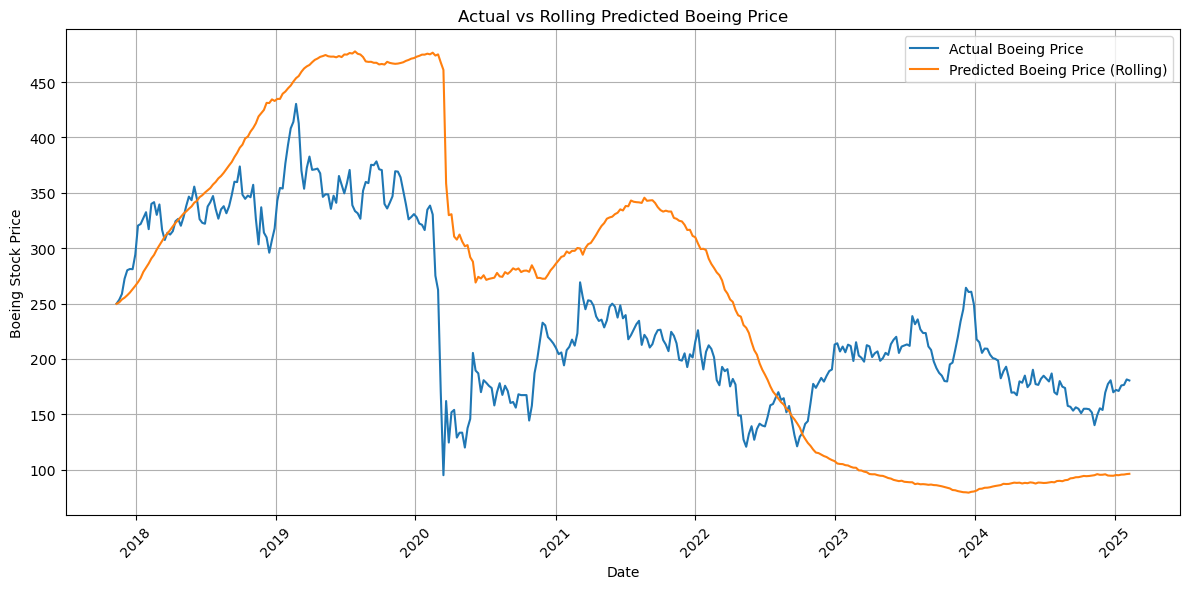

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 取起始价格
price_start = train_df['boeing'].iloc[-1]  # 训练集最后一天的价格

# 2. 还原滚动预测的价格
predicted_price_roll = [price_start * (1 + y_pred_roll[0])]
for r in y_pred_roll[1:]:
    predicted_price_roll.append(predicted_price_roll[-1] * (1 + r))
predicted_price_roll = np.array(predicted_price_roll)

# 3. 真实价格（test集）
real_price = test_df['boeing'].values
real_date = test_df['date'].values  # 日期

# 4. 绘制对比图
plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price')
plt.plot(real_date, predicted_price_roll, label='Predicted Boeing Price (Rolling)')
plt.title('Actual vs Rolling Predicted Boeing Price')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 真实价格
real_price = test_df['boeing'].values

# 滚动预测还原出的价格
# 就是 predicted_price_roll

# 1. 计算误差指标
mse = mean_squared_error(real_price, predicted_price_roll)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_price, predicted_price_roll)
mape = np.mean(np.abs((real_price - predicted_price_roll) / real_price)) * 100

# 2. 打印输出
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE: 10200.8158
RMSE: 100.9991
MAE: 89.4890
MAPE: 42.44%


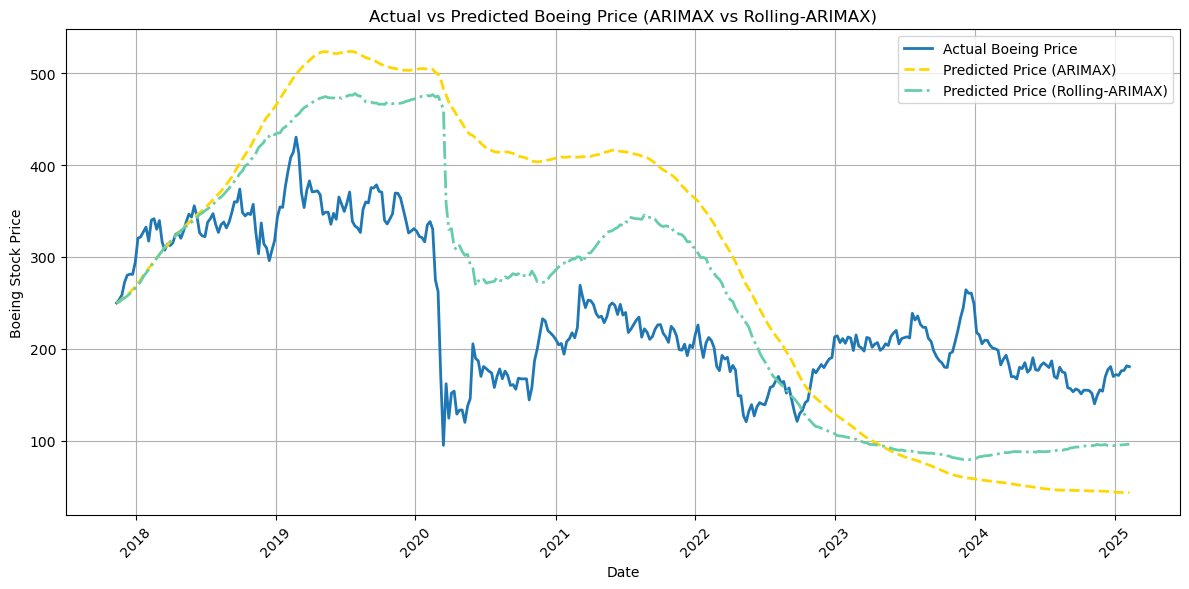

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# 起始价格
price_start = train_df['boeing'].iloc[-1]

# ARIMAX 模型预测还原
predicted_price = [price_start * (1 + y_pred.iloc[0])]
for r in y_pred.iloc[1:]:
    predicted_price.append(predicted_price[-1] * (1 + r))
predicted_price = np.array(predicted_price)

# Rolling-ARIMAX 模型预测还原
predicted_price_roll = [price_start * (1 + y_pred_roll[0])]
for r in y_pred_roll[1:]:
    predicted_price_roll.append(predicted_price_roll[-1] * (1 + r))
predicted_price_roll = np.array(predicted_price_roll)

# 真实价格和日期
real_price = test_df['boeing'].values
real_date = test_df['date'].values

# 绘图
plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price', color='C0', linewidth=2)  # 蓝色实线
plt.plot(real_date, predicted_price, label='Predicted Price (ARIMAX)', color='#FFD700', linestyle='--', linewidth=2)  # 柔和黄
plt.plot(real_date, predicted_price_roll, label='Predicted Price (Rolling-ARIMAX)', color='#66CDAA', linestyle='-.', linewidth=2)  # 柔和绿

plt.title('Actual vs Predicted Boeing Price (ARIMAX vs Rolling-ARIMAX)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
import statsmodels.api as sm
from arch import arch_model

# 1. 用train数据拟合ARIMAX
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars]
y_train = train_df['boeing_return']

arimax_model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
)
arimax_fit = arimax_model.fit(disp=False)

# 2. 拿到ARIMAX残差
residuals = arimax_fit.resid

# 3. 用残差拟合GARCH模型
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero')
garch_fit = garch_model.fit(disp='off')

# 4. 查看GARCH结果
print(garch_fit.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                1626.41
Distribution:                  Normal   AIC:                          -3246.83
Method:            Maximum Likelihood   BIC:                          -3232.48
                                        No. Observations:                  883
Date:                Wed, Apr 30 2025   Df Residuals:                      883
Time:                        19:05:15   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.4564e-05  1.007e-05      3.432  5.987e-04 [1.

C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from arch import arch_model
import matplotlib.pyplot as plt

# 定义外生变量
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars]
y_train = train_df['boeing_return']
X_test = test_df[exog_vars]
y_test = test_df['boeing_return']
real_date = test_df['date'].values

# 初始化历史数据
X_history = X_train.copy()
y_history = y_train.copy()

y_pred_arimax = []
y_volatility = []  # 保存GARCH预测的波动率

# 滚动预测
for i in range(len(X_test)):
    X_exog_next = X_test.iloc[i:i+1]

    # 1. 拟合 ARIMAX
    arimax_model = sm.tsa.SARIMAX(
        endog=y_history,
        exog=X_history,
        order=(1, 0, 1),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    arimax_fit = arimax_model.fit(disp=False)

    # 2. 用ARIMAX预测均值
    pred_mean = arimax_fit.predict(start=len(y_history), end=len(y_history), exog=X_exog_next)
    y_pred_arimax.append(pred_mean.iloc[0])

    # 3. 拿到残差，拟合GARCH
    residuals = arimax_fit.resid
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='Zero')
    garch_fit = garch_model.fit(disp='off')

    # 4. 预测下一期的方差（取条件标准差）
    forecast_variance = garch_fit.forecast(horizon=1).variance.values[-1, 0]
    forecast_volatility = np.sqrt(forecast_variance)
    y_volatility.append(forecast_volatility)

    # 5. 更新历史数据
    y_history = pd.concat([y_history, pd.Series(y_test.iloc[i])], axis=0).reset_index(drop=True)
    X_history = pd.concat([X_history, X_exog_next], axis=0).reset_index(drop=True)

# 结果转数组
y_pred_arimax = np.array(y_pred_arimax)
y_volatility = np.array(y_volatility)


C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: 

In [55]:
# 训练集最后一天价格
price_start = train_df['boeing'].iloc[-1]

# 还原预测价格
predicted_price = [price_start * (1 + y_pred_arimax[0])]
for r in y_pred_arimax[1:]:
    predicted_price.append(predicted_price[-1] * (1 + r))
predicted_price = np.array(predicted_price)

# 真实价格
real_price = test_df['boeing'].values


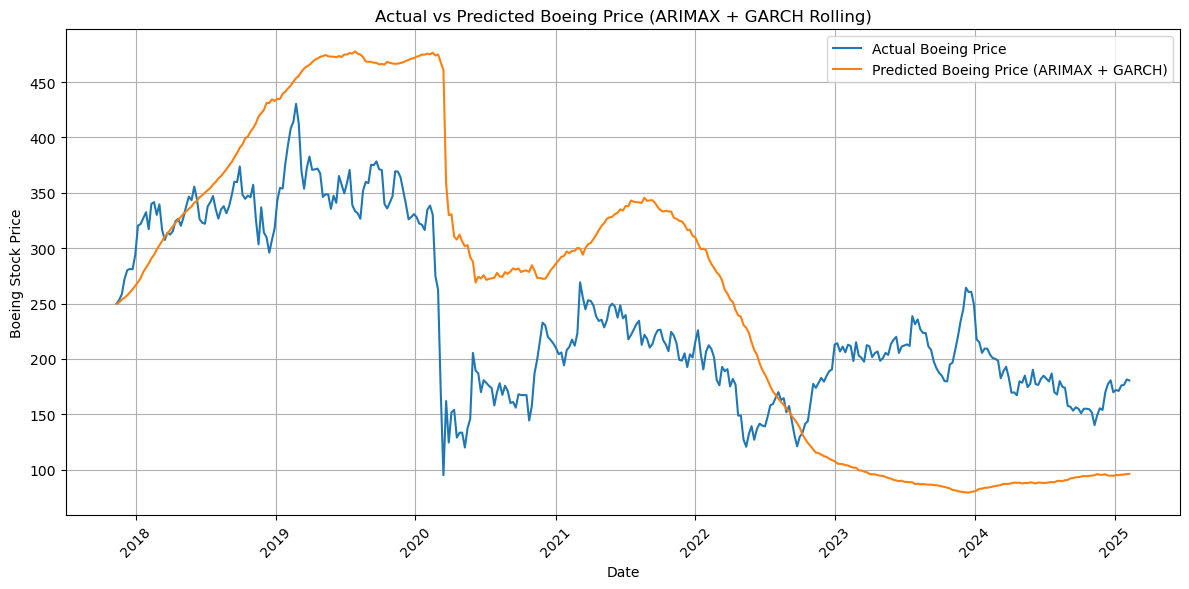

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price')
plt.plot(real_date, predicted_price, label='Predicted Boeing Price (ARIMAX + GARCH)')
plt.title('Actual vs Predicted Boeing Price (ARIMAX + GARCH Rolling)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
real_price = test_df['boeing'].values
# 1. 计算各项指标
mse = mean_squared_error(real_price, predicted_price)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_price, predicted_price)
mape = np.mean(np.abs((real_price - predicted_price) / real_price)) * 100
# 2. 打印输出
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE: 10200.8158
RMSE: 100.9991
MAE: 89.4890
MAPE: 42.44%


In [35]:
import statsmodels.api as sm
# 1. 定义解释变量和目标变量
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars]
y_train = train_df['boeing_return']

# 2. 拟合 Dynamic Regression（带外生变量的AR(1)）
dynamic_model = sm.tsa.SARIMAX(
    endog=y_train,
    exog=X_train,
    order=(1, 0, 0),  # (p,d,q)，这里只要AR(1)
    enforce_stationarity=False,
    enforce_invertibility=False
)
dynamic_fit = dynamic_model.fit(disp=False)

# 3. 展示模型结果
print(dynamic_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          boeing_return   No. Observations:                  883
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1552.527
Date:                Wed, 30 Apr 2025   AIC                          -3087.053
Time:                        19:07:01   BIC                          -3044.013
Sample:                             0   HQIC                         -3070.596
                                - 883                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DJI            0.0130      0.010      1.309      0.191      -0.006       0.032
dollar        -0.0086      0.003     -2.708      0.007      -0.015      -0.002
oil           -0.0029      0.004     -0.815      0.4

In [37]:
# 定义test集的外生变量和真实值
X_test = test_df[exog_vars]
y_test = test_df['boeing_return']
real_date = test_df['date'].values

# 进行预测
# 注意start和end设定正确：test的开始就是训练集长度
start = len(X_train)
end = start + len(X_test) - 1

y_pred_dynamic = dynamic_fit.predict(start=start, end=end, exog=X_test)


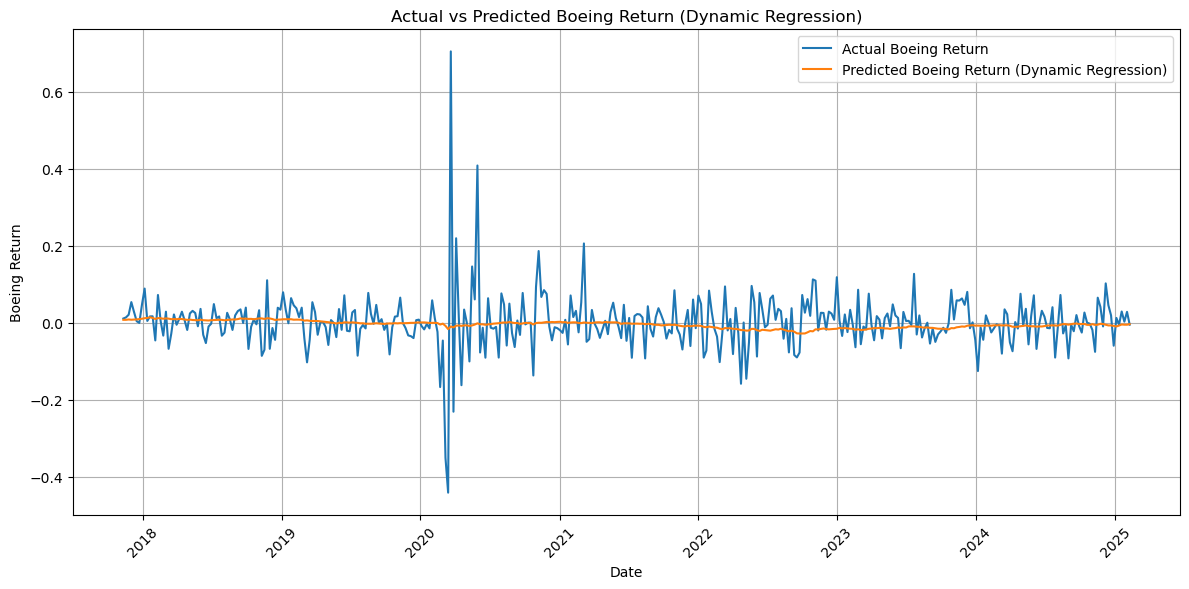

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(real_date, y_test, label='Actual Boeing Return')
plt.plot(real_date, y_pred_dynamic, label='Predicted Boeing Return (Dynamic Regression)')
plt.title('Actual vs Predicted Boeing Return (Dynamic Regression)')
plt.xlabel('Date')
plt.ylabel('Boeing Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
import numpy as np

# 训练集最后一天的真实价格（起点）
price_start = train_df['boeing'].iloc[-1]

# 用预测return累乘还原预测价格
predicted_price_dynamic = [price_start * (1 + y_pred_dynamic.iloc[0])]
for r in y_pred_dynamic.iloc[1:]:
    predicted_price_dynamic.append(predicted_price_dynamic[-1] * (1 + r))
predicted_price_dynamic = np.array(predicted_price_dynamic)

# 真实价格（来自test集）
real_price = test_df['boeing'].values


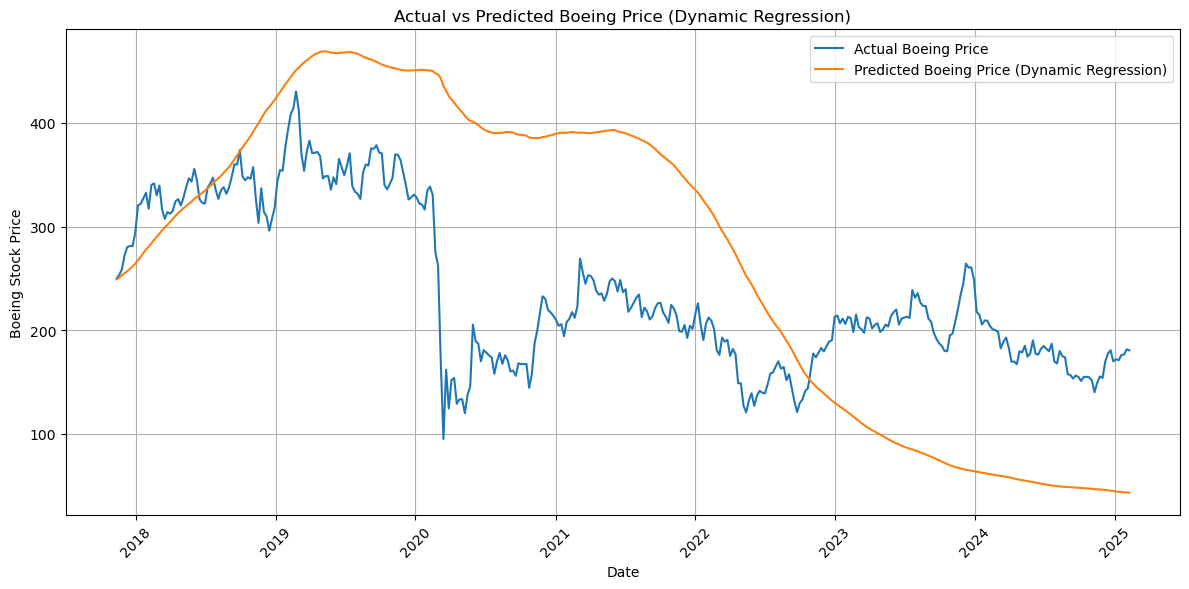

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price')
plt.plot(real_date, predicted_price_dynamic, label='Predicted Boeing Price (Dynamic Regression)')
plt.title('Actual vs Predicted Boeing Price (Dynamic Regression)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# 1. 准备
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars]
y_train = train_df['boeing_return']
X_test = test_df[exog_vars]
y_test = test_df['boeing_return']
real_date = test_df['date'].values

# 2. 初始化历史数据
X_history = X_train.copy()
y_history = y_train.copy()

# 3. 滚动预测保存
y_pred_dynamic_roll = []

# 4. 开始滚动
for i in range(len(X_test)):
    X_exog_next = X_test.iloc[i:i+1]

    # 拟合Dynamic Regression（AR(1) + 外生变量）
    model = sm.tsa.SARIMAX(
        endog=y_history,
        exog=X_history,
        order=(1, 0, 0),  # 只要AR(1)
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    model_fit = model.fit(disp=False)

    # 预测下一期return
    pred_next = model_fit.predict(start=len(y_history), end=len(y_history), exog=X_exog_next)
    y_pred_dynamic_roll.append(pred_next.iloc[0])

    # 更新历史数据，注意reset index
    y_history = pd.concat([y_history, pd.Series(y_test.iloc[i])], axis=0).reset_index(drop=True)
    X_history = pd.concat([X_history, X_exog_next], axis=0).reset_index(drop=True)

# 5. 转成数组
y_pred_dynamic_roll = np.array(y_pred_dynamic_roll)


C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\17376\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

In [47]:
# 训练集最后一天价格，作为还原起点
price_start = train_df['boeing'].iloc[-1]

# 根据预测的return还原价格
predicted_price_dynamic_roll = [price_start * (1 + y_pred_dynamic_roll[0])]
for r in y_pred_dynamic_roll[1:]:
    predicted_price_dynamic_roll.append(predicted_price_dynamic_roll[-1] * (1 + r))
predicted_price_dynamic_roll = np.array(predicted_price_dynamic_roll)

# 真实价格（test集）
real_price = test_df['boeing'].values


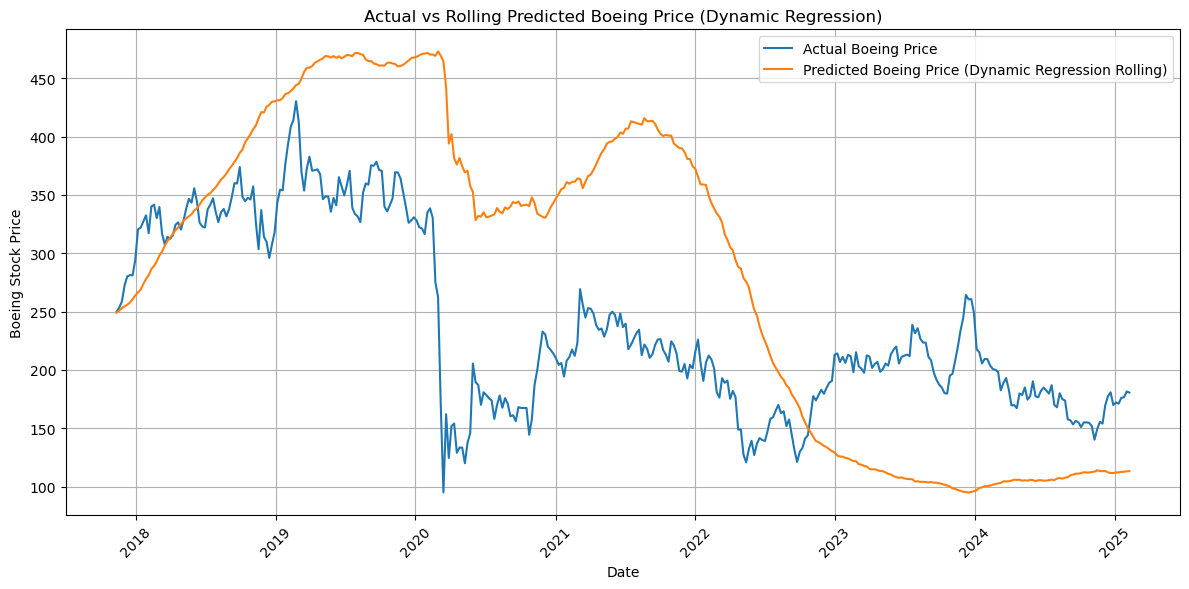

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price')
plt.plot(real_date, predicted_price_dynamic_roll, label='Predicted Boeing Price (Dynamic Regression Rolling)')
plt.title('Actual vs Rolling Predicted Boeing Price (Dynamic Regression)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# 计算误差
mse = mean_squared_error(real_price, predicted_price_dynamic_roll)
rmse = np.sqrt(mse)
mae = mean_absolute_error(real_price, predicted_price_dynamic_roll)
mape = np.mean(np.abs((real_price - predicted_price_dynamic_roll) / real_price)) * 100

# 输出
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


MSE: 14233.5174
RMSE: 119.3043
MAE: 103.4512
MAPE: 50.22%


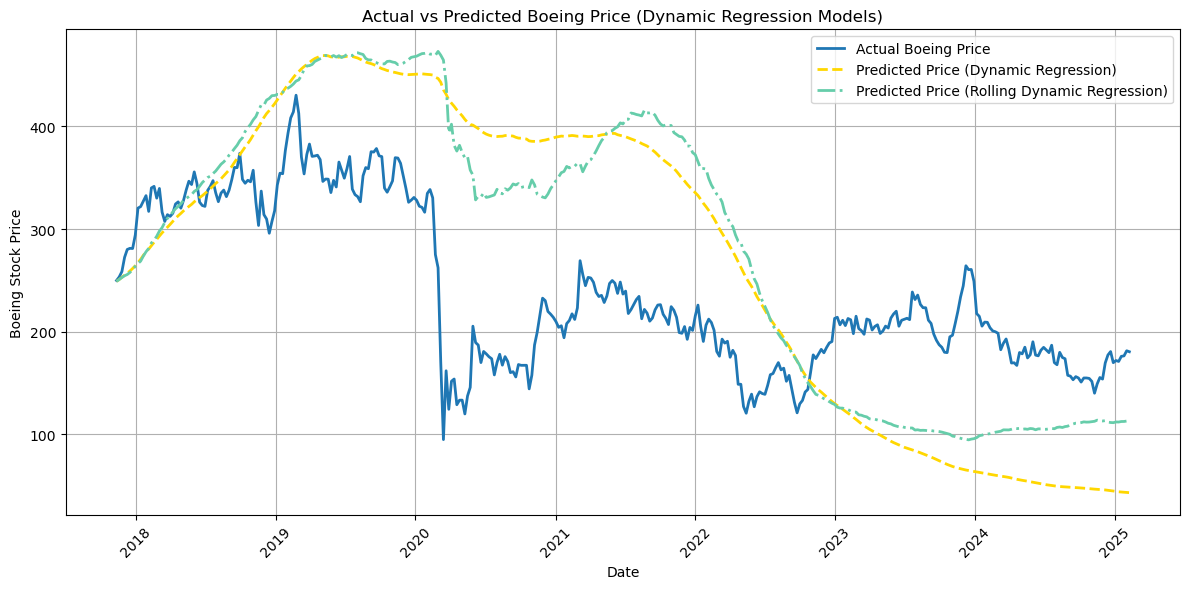

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 实际价格（蓝色）
plt.plot(real_date, real_price, label='Actual Boeing Price', color='C0', linewidth=2)

# Dynamic Regression（黄色）
plt.plot(real_date, predicted_price_dynamic, label='Predicted Price (Dynamic Regression)', color='#FFD700', linestyle='--', linewidth=2)

# Rolling Dynamic Regression（绿色）
plt.plot(real_date, predicted_price_dynamic_roll, label='Predicted Price (Rolling Dynamic Regression)', color='#66CDAA', linestyle='-.', linewidth=2)

# 图形设置
plt.title('Actual vs Predicted Boeing Price (Dynamic Regression Models)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


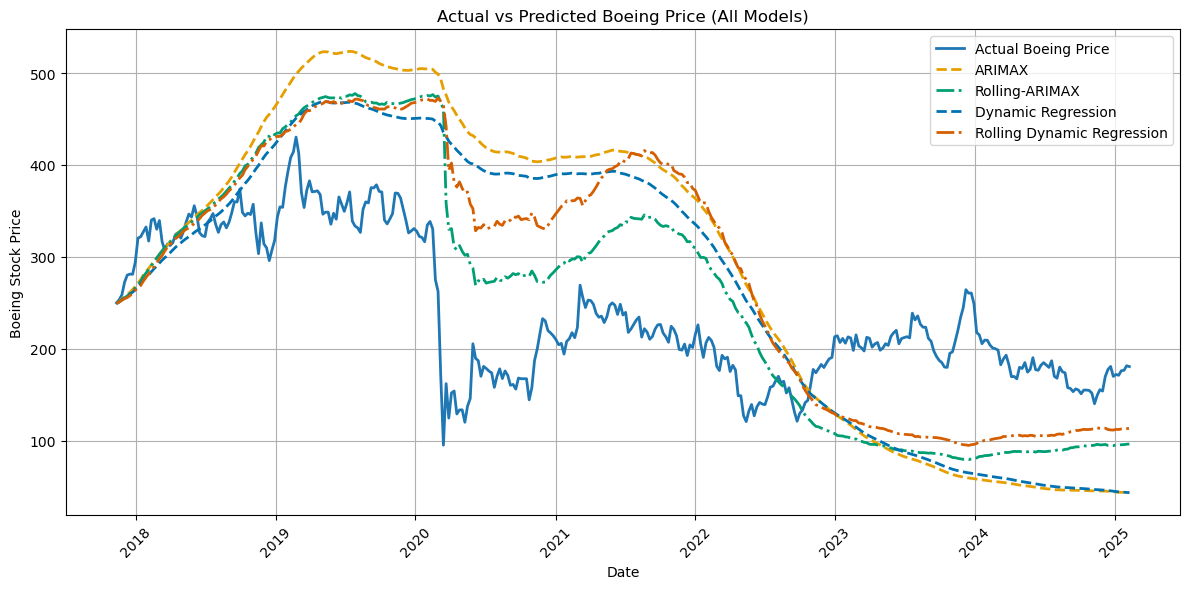

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# 还原 ARIMAX
predicted_price = [price_start * (1 + y_pred.iloc[0])]
for r in y_pred.iloc[1:]:
    predicted_price.append(predicted_price[-1] * (1 + r))
predicted_price = np.array(predicted_price)

# 还原 Rolling-ARIMAX
predicted_price_roll = [price_start * (1 + y_pred_roll[0])]
for r in y_pred_roll[1:]:
    predicted_price_roll.append(predicted_price_roll[-1] * (1 + r))
predicted_price_roll = np.array(predicted_price_roll)

# 真实价格和日期
real_price = test_df['boeing'].values
real_date = test_df['date'].values

# 绘图
plt.figure(figsize=(12, 6))

# 实际价格：蓝色
plt.plot(real_date, real_price, label='Actual Boeing Price', color='C0', linewidth=2)

# 模型预测线：颜色对比明显
plt.plot(real_date, predicted_price, label='ARIMAX', color='#E69F00', linestyle='--', linewidth=2)
plt.plot(real_date, predicted_price_roll, label='Rolling-ARIMAX', color='#009E73', linestyle='-.', linewidth=2)
plt.plot(real_date, predicted_price_dynamic, label='Dynamic Regression', color='#0072B2', linestyle='--', linewidth=2)
plt.plot(real_date, predicted_price_dynamic_roll, label='Rolling Dynamic Regression', color='#D55E00', linestyle='-.', linewidth=2)

# 图形设置
plt.title('Actual vs Predicted Boeing Price (All Models)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [79]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [81]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 选解释变量
exog_vars = ['DJI', 'dollar', 'oil', 'GDP', 'CPI', 'delivery', 'Al']
X_train = train_df[exog_vars].values
y_train = train_df['boeing_return'].values

# LSTM要求输入是3D形状: (samples, timesteps, features)
# 这里简单处理成 timestep=1（单步输入）
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))


In [83]:
# 建立模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
model.add(Dense(1))  # 输出一个return

# 编译模型
model.compile(optimizer='adam', loss='mse')
# 拟合
history = model.fit(X_train_lstm, y_train, epochs=100, batch_size=16, verbose=1)


Epoch 1/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0049
Epoch 2/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 3/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017  
Epoch 4/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017
Epoch 5/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020
Epoch 6/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 7/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015
Epoch 8/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022
Epoch 9/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018
Epoch 10/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 11/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016   
Epoch 12/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019
Epoch 13/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017  
Epoch 14/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018
Epoch 15/100
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.00

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


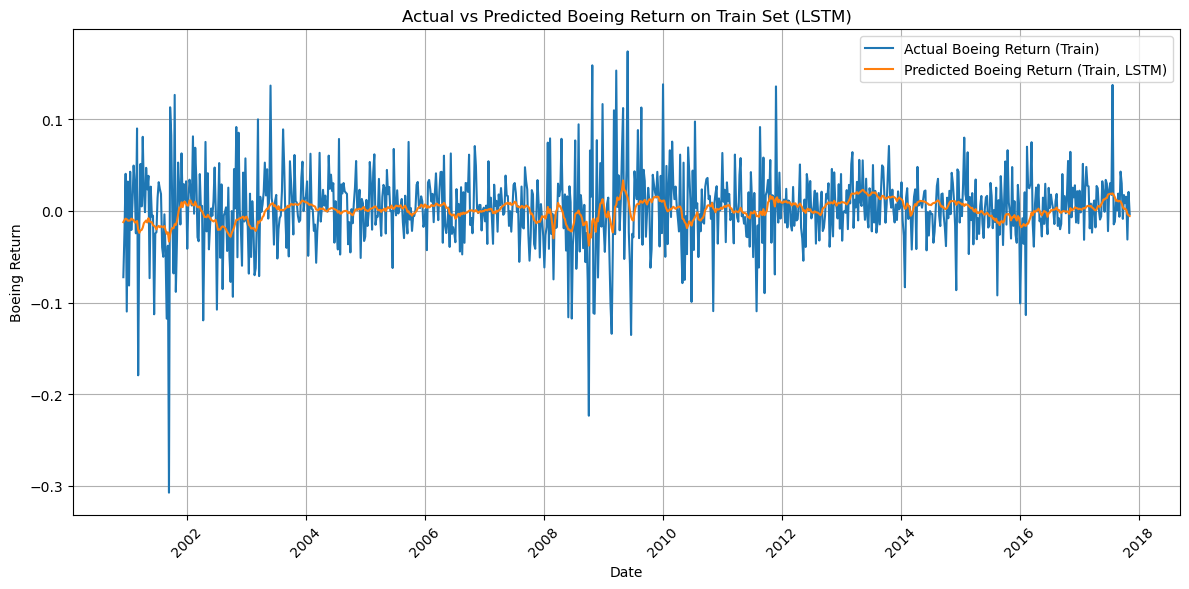

In [85]:
# 用训练好的LSTM模型对train数据进行预测
y_train_pred = model.predict(X_train_lstm).flatten()  # 预测结果是二维，要flatten成一维
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_df['date'].values, y_train, label='Actual Boeing Return (Train)')
plt.plot(train_df['date'].values, y_train_pred, label='Predicted Boeing Return (Train, LSTM)')
plt.title('Actual vs Predicted Boeing Return on Train Set (LSTM)')
plt.xlabel('Date')
plt.ylabel('Boeing Return')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [87]:
# 准备 test数据
X_test = test_df[exog_vars].values
y_test = test_df['boeing_return'].values
real_date = test_df['date'].values

# LSTM需要3D输入 (samples, timesteps, features)
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 预测
y_test_pred = model.predict(X_test_lstm).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [89]:
# 训练集最后一天的实际价格，作为起点
price_start = train_df['boeing'].iloc[-1]

# 还原预测价格曲线
predicted_price_lstm = [price_start * (1 + y_test_pred[0])]
for r in y_test_pred[1:]:
    predicted_price_lstm.append(predicted_price_lstm[-1] * (1 + r))
predicted_price_lstm = np.array(predicted_price_lstm)

# 真实价格
real_price = test_df['boeing'].values


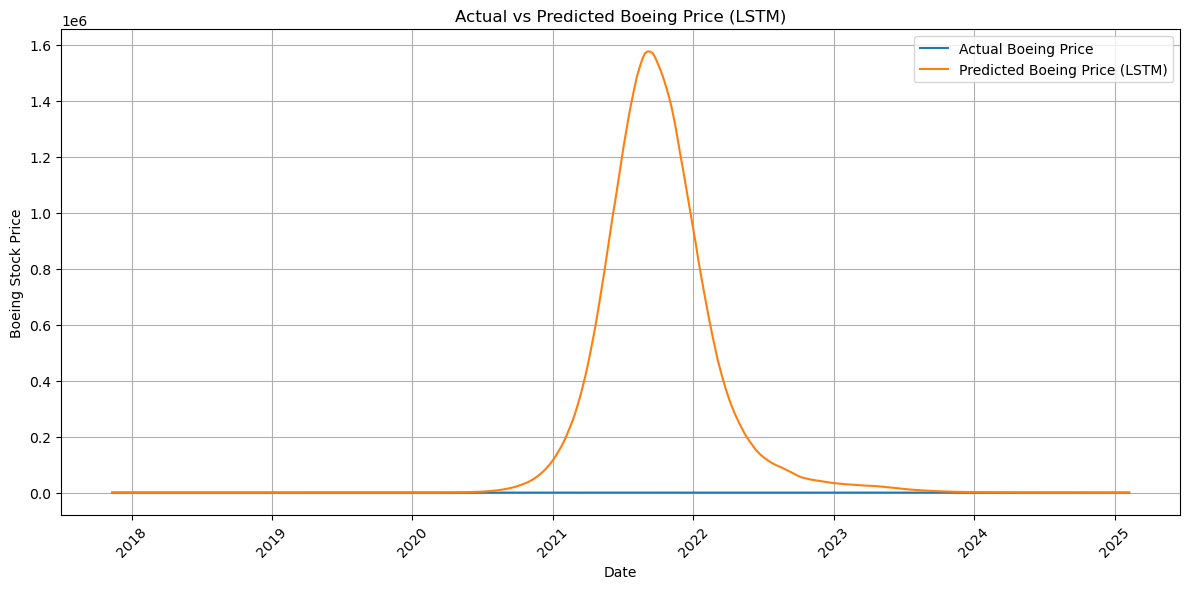

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(real_date, real_price, label='Actual Boeing Price')
plt.plot(real_date, predicted_price_lstm, label='Predicted Boeing Price (LSTM)')
plt.title('Actual vs Predicted Boeing Price (LSTM)')
plt.xlabel('Date')
plt.ylabel('Boeing Stock Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
